In [1]:
#import packages 
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

import numpy as np
import matplotlib.pyplot as plt

import collections
import os

import logging
import pickle
from tqdm import tqdm



logger = logging.getLogger(__name__)

import networkx as nx
seed = 20160  # seed random number generators for reproducibility

In [2]:
#problem setting 
#sub-gaussian 
class Environment:
    def __init__(self, config):
        self.T = config['T']
        self.M = config['M']
        self.c = config['c']

        self.mu = config['mu']
        self.sigma = config['sigma']
        self.h = config['h']
        #self.mu_opt_M = np.sort(self.mu)[-self.M:]
        self.K = config['K']
        logger.info(f"Created environment with M = {self.M}, mu = {self.mu},h= {self.h}, T = {self.T}, K = {self.K}")

    def __str__(self):
        return f"M{self.M}-K{self.K}-mu{str(self.mu)}"

    def update(self, t):
        pass

    def draw(self, arms, option, sensing=False):
        counts = collections.Counter(arms)
        rewards = np.zeros((self.M,))
        for player in range(self.M):
            #rewards[player] = np.random.normal(self.mu[player,arms[player]], self.sigma[player, arms[player]])
            if np.random.rand() <= self.mu[player,arms[player]]:
                rewards[player]=1
            else:
                rewards[player]=0
            #rewards[player] = np.random.binomial(1, self.mu[player,arms[player]], 1)
        if option == 'random':
            graph = nx.erdos_renyi_graph(self.M,self.c,seed)
        elif option == 'dis':
            graph = nx.erdos_renyi_graph(self.M-1,1,seed)
            graph.add_node(self.M-1)
            #the last node is the isolated point that has a heterogeneous mean reward value 
            #should change the mean value accordingly 
        elif option == 'path':
            graph = nx.path_graph(self.M)


        return rewards, graph
    
    

In [3]:

class LocalMAB:
    def __init__(self, num_agents, num_arms):
        self.num_arms = num_arms
        #self.true_reward_means = true_reward_means
        self.q_local = np.zeros(num_arms)  # Estimated action values
        self.q_network = np.zeros(num_arms)  # Estimated action values
        self.q_var = np.zeros(num_arms)
        self.counts_local = np.zeros(num_arms)  # Counts of each action taken
        self.counts_network = np.zeros(num_arms)  # Counts of each action taken
        self.total_reward = 0
        self.c1 = 4
        self.c2 = 0
        self.epsilon = 0.1  # Exploration rate
        self.P = np.zeros(num_agents)
        self.P1 = np.zeros(num_agents)
        self.ucb = 0
        self.M = num_agents
        self.comm_reward = {}
        self.comm_counts = {}
        self.comm_reward_network = {}
        self.comm_counts_network = {}
        self.tmp = {}
        self.exp_reward = 0
        self.exp_reward_list = []
        self.regret = 0
        self.regret_list = []


    def choose_action(self, t, flag, c1):
        if flag:  # Corrected condition
            # Explore with probability epsilon
            return np.random.choice(self.num_arms)
        else:
            # Exploit the current estimates
            #self.counts_local[i]
            self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]
            self.ucb = [(self.q_network[i]+ self.q_var[i]) for i in range(len(self.q_network))]
            return np.argmax(self.ucb)

    def update(self, chosen_action, reward, exp_reward):
        # Update action values using sample-average method
        self.counts_local[chosen_action] += 1
        self.q_local[chosen_action] = (reward + self.q_local[chosen_action]*(self.counts_local[chosen_action]-1)) / self.counts_local[chosen_action]  # Corrected action counts
        self.total_reward += reward
        self.exp_reward += exp_reward
        self.exp_reward_list.append(self.exp_reward)
    
    def update_global(self, chosen_action, reward):
        # Update action values using sample-average method
        #self.counts_local[chosen_action] += 1
        a = 0
        for i in range(self.num_arms):  # Corrected loop
            for j in range(self.M):
                if self.P[j] >0:
                    a = max(self.comm_counts[j][i], a)  # Corrected assignment
            self.counts_network[i] = max(a, self.counts_local[i])
        #self.q_local[chosen_action] += (reward - self.q_local[chosen_action]) / self.counts_local[chosen_action]  # Corrected action counts
        d = (1 - np.sum(self.P1))/config['M']
        #print(self.comm_reward_network)
        for k in range(config['K']):
            self.q_network[k] = sum([(self.P1[j] * self.comm_reward_network[j][k] + d*self.comm_reward[j][k]) for j in range(config['M']-1)])


In [4]:
#problem instances
config = {}
config['T'] = 2000
config['L'] = 50
config['M'] = 5
config['c'] = 1
config['K'] = 2
config['c1'] = 0.5
config['h'] = 0.1
config['scale'] = 0.2
config['mu'] = np.ones((config['M'], config['K']))
print(config['mu'])
for k in range(config['K']):
    config['mu'][:,k] = np.linspace(0.1,0.1+(k+1)*config['h']/config['K'],config['M'])
config['sigma'] = config['scale']*np.ones((config['M'], config['K']))
mu = config['mu']
#mu = np.array(sorted(mu, reverse=True))
print(mu)
#bandit = MultiArmedBandit(num_arms, true_reward_means)
T = config['T']
num_agents =config['M']
L = config['L']
para = 0.6
tau = 1
#P = np.zeros((num_agents, num_arms))
environment = Environment(config)
bandit = []
num_arms = config['K']
print(num_arms)
for player in range(config['M']):
    bandit.append(LocalMAB(num_agents, config['K']))


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]
2


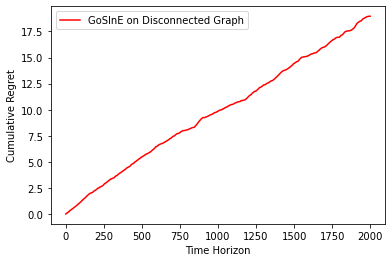

In [5]:

#existing benchmarks; whether to include all the algorithms as in the table 
#stochastic settings and disconnected graphs 


#Algorithms:

#Gossip 
import warnings

warnings.filterwarnings("ignore")


def stickyarms(n, K):       # Initializing the set maintained by the agents
    arms = np.zeros((np.int(np.ceil(K/n)+2), n))
    for p in range(n):
        for q in range(np.int(np.ceil(K/n)+2)):
            if (np.mod(p*np.ceil(K/n),K)+q+1 > K):
                arms[q,p] = np.mod(np.mod(p*np.ceil(K/n),K)+q+1-K,K)
            else:
                arms[q,p] = np.mod(p*np.ceil(K/n),K)+q+1
    arms=arms-1
    return arms.astype(np.int64)
# Structure of the set maintained by the agents:
# Columns denote the agents, where each agent has ceil(K/n)+2 arms, thus ceil(K/n)+2 rows.
# The first ceil(K/n) arms maintained by every agent constitute its sticky set,
# which remains fixed at all times.
# The ceil(K/n)+1 th arm is U and ceil(K/n)+2 th arm is L.
# U is updated by choosing the most played arm among U and L in a phase.
# L is the least played arm in previous phase, which will be replaced by the recommendation pulled by the agent
# at the end of a phase.


def ucb(mu, alpha, regret, ucb_score, mu_bar, T, idx, s):   # Subroutine which plays UCB for the chosen arm
    T[idx]=T[idx]+1         # Number of times the arm being played incremented by 1
    if np.random.rand() <= mu[idx]:     # When a reward of 1 is received after playing the arm
        mu_bar[idx]=(((T[idx]-1)*mu_bar[idx])+1)/T[idx]
    else:            # When a reward of 0 is received after playing the arm
        mu_bar[idx]=((T[idx]-1)*mu_bar[idx])/T[idx]
    regret=regret+(mu[-1]-mu[idx])     # Regret incurred 
    ucb_score=mu_bar+np.sqrt(alpha*np.log(s+1)/T);  # Updating UCB score for next time step
    return regret, ucb_score, mu_bar, T

#Note: this getarm function routine takes the adjacency matrix of the graph as input
#and works only for the case when the neighbors of the agent are chosen equally likely.
#For a general gossip matrix P, this getarm function has to be modified
#to pick the agent sampled from P(.,ag) from where ag pulls a recommendation 
def getarm(arms, neighbor, ag, delta_T):
    nb=np.nonzero(neighbor[:,ag])[0] # neighbors of agent ag
    #print(nb)
    rec_ag=nb[np.random.randint(np.size(nb))] # picking the neighbor whose best arm recommendation will be pulled by ag  
    rec_id=arms[np.argmax(delta_T[arms[:,rec_ag],rec_ag]),rec_ag]  #  estimated best arm of the neighbor picked by ag
    return rec_id       


n = config['M']         # number of agents
K = config['K']        # number of arms
m = 5         # number of phases
alpha = 4      # UCB parameter
itr=1         # Number of runs over the same instance for generating confidence plots
mu=config['mu']
t = config['T']            # length of time horizon, parametrized by m
rs=np.zeros((t,itr))  # regret for separate single agent playing the same MAB instance over all itr runs
rpa_comp=np.zeros((t,itr))  # regret per agent for complete graph over all itr runs

# adjacency matrix 
rewards, Graph = Environment(config).draw(np.zeros(n, dtype=int),'dis')

neighbor = []
neighbor_comp = np.zeros((n,n), int)
for line in nx.generate_adjlist(Graph):
    neighbor.append(list(map(int,str(line).split(" "))))
for i in np.arange(len(neighbor)):
    for j in np.arange(len(neighbor)):
        if j in neighbor[i]:
            neighbor_comp[i][j] = int(1)
#np.fill_diagonal(neighbor_comp, 0)

    
regret = 0

for l in range(itr):
    j=1     # to keep track of which phase we are in
    ucb_score_single=np.Inf*np.ones(K)  # ucb score of a separate single agent playing the same MAB instance
    T_single=np.zeros(K)    # number of times an arm is played by the separate single agent playing the same MAB instance
    mu_bar_single=np.zeros(K)   # average mean reward of the arms estimated by the separate single agent playing the same MAB instance
    regret_single=np.zeros(t)   # regret incurred by the separate single agent playing the same MAB instance
    mu_bar_comp=np.zeros((K,n)) # average mean reward of the arms estimated by the agents connected by a complete graph
    T_comp=np.zeros((K,n))  # number of times an arm is played by the agents connected by a complete graph
    T_prev_comp=np.zeros((K,n)) # number of times an arm is played by the agents connected by a complete graph till the previous phase
    ucb_score_comp=np.Inf*np.ones((K,n))    # UCB scores of arms for agents connected by a complete graph 
    regret_comp=np.zeros((t,n)) # Regret incurred by agents connected by a complete graph
    arms_comp = stickyarms(n, K)    # Initializing the set maintained by agents connected by a complete graph
        
    for s in range(t):
        # UCB played by the separate single agent playing the same MAB instance
        idx_single=np.argmax(ucb_score_single)  # Selecting the arm with highest UCB score 
        #regret_single[s], ucb_score_single, mu_bar_single, T_single=ucb(mu, alpha, ucb_score_single, mu_bar_single, T_single, idx_single, s+1)
        # playing UCB with the arm chosen above
        
        # Multi-Agent UCB on complete graph
        for ag in range(n):
            idx_comp=arms_comp[np.argmax(ucb_score_comp[arms_comp[:,ag],ag]),ag] # Selecting the arm with highest UCB score among the set of arms maintained
            regret_comp[s,ag], ucb_score_comp[:, ag], mu_bar_comp[:, ag], T_comp[:, ag]=ucb(mu[ag,:], alpha, regret_comp[s-1,ag], ucb_score_comp[:,ag], mu_bar_comp[:,ag], T_comp[:,ag], idx_comp, s+1)
            # playing UCB with the arm chosen above

        # Pulling recommendation at the end of the phase          
        if s==(j**3)-1:
            delta_T_comp=T_comp-T_prev_comp  #  to keep track of how many times an arm is played in previous phase
            for ag in range(n):
                # Checking which arm out of U and L is played the least number of times and swapping them
                if (delta_T_comp[arms_comp[int(np.ceil(K/n)),ag],ag]<delta_T_comp[arms_comp[int(np.ceil(K/n)+1),ag],ag]):
                    tmp=arms_comp[int(np.ceil(K/n)),ag]
                    arms_comp[int(np.ceil(K/n)),ag]=arms_comp[int(np.ceil(K/n)+1),ag]
                    arms_comp[int(np.ceil(K/n)+1),ag]=tmp
                rec_id_comp=getarm(arms_comp,neighbor_comp,ag,delta_T_comp) # Recommendation received after pulling from one of the neighbors 
                if (np.size(np.where(arms_comp[:,ag]==rec_id_comp))==0):    # Checking whether the received recommendation is in the set of the arms maintained by ag or not
                    arms_comp[int(np.ceil(K/n))+1,ag]=rec_id_comp # if not present, replace it with L
            T_prev_comp=np.copy(T_comp) # Stores the number of times an arm was played till the previous phase by all agents
            j=j+1   # updating the phase
    
    #rs[:,l]=np.copy(regret_single)
    rpa_comp[:,l]=np.mean(regret_comp,axis=1)   # per agent regret for lth run

# computing mean and confidences for the regret incurred over time t over itr runs
#rs_avg=np.mean(rs,axis=1)   
#rs_lower=np.percentile(rs,2.5,axis=1)
#rs_upper=np.percentile(rs,97.5,axis=1)
rpa_comp_avg=np.mean(rpa_comp,axis=1)
rpa_comp_lower=np.percentile(rpa_comp,2.5,axis=1)
rpa_comp_upper=np.percentile(rpa_comp,97.5,axis=1)

x=np.arange(t)

GosInE = rpa_comp_avg
# Plotting
#plt.plot(x,rs_avg,label='No Communication',color='b')
#plt.fill_between(x,rs_lower,rs_upper,color='b')
plt.plot(x,rpa_comp_avg,label='GoSInE on Disconnected Graph',color='red')
#plt.fill_between(x,rpa_comp_lower,rpa_comp_upper,color='g')
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

In [6]:
#Algorithms: DDUCB 
import numpy as np
import pickle
from utils import *
import os


def DDUCB(P, n, T, lambda_2, distributions, epsilon, eta, variance, mu_1, accel=False, C_small=False):
    regret = [0]
    lambda_2 = np.abs(lambda_2)
    K = len(distributions)
    C = None
    if accel:
        if C_small:
            C = int(np.ceil(np.log(2*n/epsilon)/np.sqrt(2*np.log(1/lambda_2))))
            C /= 3
            C = int(C)
        else:
            C = int(np.ceil(np.log(2*n/epsilon)/np.sqrt(2*np.log(1/lambda_2))))
    else:
        if C_small:
            C = int(np.ceil(np.log(2*n/epsilon)/np.sqrt(2*np.log(1/lambda_2))))
        else:
            C = int(np.ceil(np.log(n/epsilon)/np.log(1/lambda_2)))
    print('C: {}'.format(C))

    first_pulls = np.array([np.array([distributions[i]() for i in range(K)]) for j in range(n)])
    beta = RewNumPulls(n, rewards_array=first_pulls, pulls_array=np.ones((n, K)))
    alpha = RewNumPulls(n,rewards_array=beta.rewards/K, pulls_array=beta.pulls/K)
    gamma = RewNumPulls(n, rewards_array=np.zeros((n, K)), pulls_array=np.zeros((n, K)))
    delta = RewNumPulls(n, rewards_array=np.zeros((n, K)), pulls_array=np.zeros((n, K)))

    unaccel_mixer = None
    if accel:
        # Sparse should be better here
        mixer = AccelMix(P, lambda_2, C, sparse=True)
    else:
        # It is not clear if sparsity is better in this case
        mixer = UnaccelMix(P, lambda_2, C, sparse=False)
        #mixer = UnaccelMix(P, lambda_2, C, sparse=True)
    t = K
    s = K
    mixer = UnaccelMix(P=P, lambda_2=lambda_2, C=1, sparse=True)
    accum = None
    while t <= T:
        for r in range(10):
            accum = 0
            for i in range(n):
                UCBs = np.array([alpha.rewards[i][k]/alpha.pulls[i][k] +
                                 np.sqrt(2*eta*variance*np.log(s)/(n*alpha.pulls[i][k])) for k in range(K)])
                k_star = np.argmax(UCBs)
                u = distributions[k_star]()
                accum += u
                gamma.rewards[i][k_star] += u
                gamma.pulls[i][k_star] += 1
                # It also works adding this
                #'''
                alpha.rewards[i][k_star] += u/n
                alpha.pulls[i][k_star] += 1/n
                s += 1
                #'''
            regret.append(regret[-1] + n*mu_1-accum)
            t += 1
            if t > T:
                print('Number of pulls per arm (best means first)')
                print(np.sum(alpha.pulls, axis=0))
                return regret
            #now = time.time()
            #if  int(later - now)
            beta.rewards = mixer.mix(beta.rewards)
            beta.pulls = mixer.mix(beta.pulls)
            #print(t)

        # It also works adding this
        '''
        if not unaccel_mixer:
            unaccel_mixer = UnaccelMix(P, lambda_2, C, sparse=False)

        delta.rewards = unaccel_mixer.mix(delta.rewards)
        delta.pulls = unaccel_mixer.mix(delta.pulls)
        s += 1
        #'''
        s = (t-C)*n
        if accel:
            delta.rewards += beta.rewards
            delta.pulls += beta.pulls
            alpha.rewards = delta.rewards
            alpha.pulls = delta.pulls
            beta.rewards = gamma.rewards
            beta.pulls = gamma.pulls
            gamma.rewards = np.zeros((n, K))
            gamma.pulls = np.zeros((n, K))
        else:
            alpha.rewards = beta.rewards
            alpha.pulls = beta.pulls
            beta.rewards += gamma.rewards
            beta.pulls += gamma.pulls
            gamma.rewards = np.zeros((n, K))
            gamma.pulls = np.zeros((n, K))

    return regret


def landgren_bandits(P, n, T, lambda_2, distributions, epsilon_c, gamma, variance, mu_1):
    regret = [0]
    lambda_2 = np.abs(lambda_2)
    K = len(distributions[0])
    first_pulls = np.array([np.array([distributions[j][k]() for k in range(K)]) for j in range(n)])
    estim = RewNumPulls(n,rewards_array=first_pulls, pulls_array=np.ones((n,K)))
    t = 1
    accum = None
    UCBs = None
    mixer = UnaccelMix(P=P, lambda_2=lambda_2, C=1, sparse=True)
    while t <= T:
        accum = 0
        for i in range(n):
            k = 1
            UCBs = np.array([estim.rewards[i][k]/estim.pulls[i][k] +
                             np.sqrt((estim.pulls[i][k]+epsilon_c[i])*2*gamma*variance*np.log(t)/(n*(estim.pulls[i][k]**2))) for k in range(K)])
            k_star = np.argmax(UCBs)
            u = distributions[i][k_star]()
            accum += u
            estim.rewards[i][k_star] += u
            estim.pulls[i][k_star] += 1
            estim.rewards = mixer.mix(estim.rewards)
            estim.pulls = mixer.mix(estim.pulls)

        regret.append(regret[-1] + mu_1 -accum/n)
        t += 1

    print(np.sum(estim.pulls, axis=0))
    return regret


def main(n, T, save = True, rerun=False, type_P='cycle', dducb_in=[], landgren_in=[], mus=[1, 0.8], sigma=None):
    print('n =',n, type_P)
    # The code assumes A defines a graph with regular degree and the matrix P is doubly stochastic,
    P = compute_P(n, type=type_P)

    print('computing constants')
    epsilon_c, lambda_2 = compute_constants(P, n)
        
    sigma = 1
    #print(sigma)
    distributions = []
    #mus = sorted(mus, key=lambda x: -x)
    mu_1 = 0
    for i in np.arange(n):
        mu_tmp = mus[i]
        mu_1 += mu_tmp[-1]
    #print(len(mus))
    distributions = [[lambda mu=mu, sigma=sigma:np.random.normal(mu, sigma) for mu in mus[i]] for i in np.arange(len(mus))]

    
    mu_1 = mu_1/n
    #print(distributions)
    gamma = 2
    landgren = []
    for gamma in landgren_in:
        regret_landgren = landgren_bandits(P, n, T, lambda_2, distributions, epsilon_c, gamma=gamma, variance=sigma*sigma, mu_1=mu_1)
        landgren.append((regret_landgren, r'coopUCB $\gamma$={}'.format(gamma)))

    dducb = []
    #'''
    print('Running DDUCB')
    eta = 2
    epsilon= 1/22
    #epsilon= 1/7
    #for C_small, accel in dducb_in:
      #  regret_dducb = DDUCB(P, n, T, lambda_2, distributions, epsilon=epsilon, eta=eta, variance=sigma*sigma, mu_1=mus[0], accel=accel, C_small=C_small)
      #  dducb.append((regret_dducb, 'DDUCB\_{}{}'.format('accel' if accel else 'unaccel', '\_Csmall' if C_small else '')))
    #'''
    all = landgren #+ dducb
    #plot(all, n, T, type_P, sigma, K=len(distributions))
    return all

itr = 20 

regret_0 = []
regret_1 = []

for l in range(itr):
    C_acc = (False, True) # (C, accel)
    Csmall_unacc = (True, False) # (C_small, unaccel)
    dducb_instances = [C_acc]
    landgren_instances = [2]
    mus = config['mu']
    sigma = config['sigma'][0][0]
    regret = main(5, 2000, save=False, rerun=False, type_P='cycle', dducb_in=dducb_instances, landgren_in=landgren_instances, mus = config['mu'])
    b_0 = np.asarray(list(regret[0][0]))
    #b_1 = np.asarray(list(regret[1][0]))
    regret_0.append(b_0)
    #regret_1.append(b_1)
    
    #main(200, 10000, save=False, rerun=False, type_P='cycle', dducb_in=dducb_instances, landgren_in=landgren_instances, mus=mus)
#main(100, 10000, save=False, rerun=False, type_P='grid', dducb_in=dducb_instances, landgren_in=landgren_instances, mus=mus)
#main(225, 10000, save=False, rerun=False, type_P='grid', dducb_in=dducb_instances, landgren_in=landgren_instances, mus=mus)



n = 5 cycle
computing constants
[4154. 5856.]
Running DDUCB
n = 5 cycle
computing constants
[4011. 5999.]
Running DDUCB
n = 5 cycle
computing constants
[4144. 5866.]
Running DDUCB
n = 5 cycle
computing constants
[5330. 4680.]
Running DDUCB
n = 5 cycle
computing constants
[4795. 5215.]
Running DDUCB
n = 5 cycle
computing constants
[4601. 5409.]
Running DDUCB
n = 5 cycle
computing constants
[5904. 4106.]
Running DDUCB
n = 5 cycle
computing constants
[4030. 5980.]
Running DDUCB
n = 5 cycle
computing constants
[4029. 5981.]
Running DDUCB
n = 5 cycle
computing constants
[4606. 5404.]
Running DDUCB
n = 5 cycle
computing constants
[4164. 5846.]
Running DDUCB
n = 5 cycle
computing constants
[5980. 4030.]
Running DDUCB
n = 5 cycle
computing constants
[4128. 5882.]
Running DDUCB
n = 5 cycle
computing constants
[4499. 5511.]
Running DDUCB
n = 5 cycle
computing constants
[4008. 6002.]
Running DDUCB
n = 5 cycle
computing constants
[4155. 5855.]
Running DDUCB
n = 5 cycle
computing constants
[4260. 5

In [7]:
CoopUCB=np.mean(regret_0, 0)
#DDUCB=np.mean(regret_1, 0)

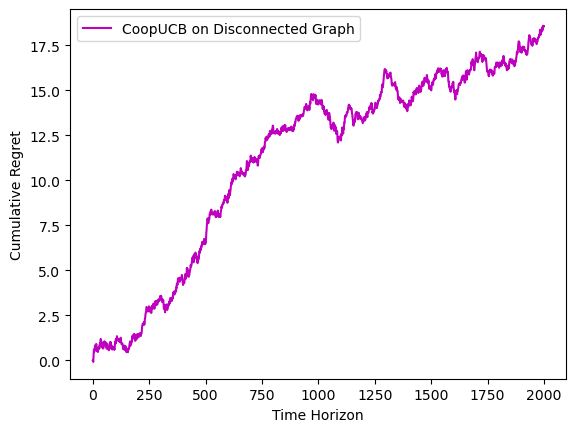

In [8]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

mpl.pyplot.plot(x,CoopUCB[:-1],  label='CoopUCB on Disconnected Graph',color='m')

#mpl.pyplot.plot(x,DDUCB[:],  label='DDUCB on Disconnected Graph',color='m')



mpl.pyplot.xlabel('Time Horizon')
mpl.pyplot.ylabel('Cumulative Regret')

mpl.pyplot.legend()
mpl.pyplot.show()

In [9]:
#Algorithms: Gossip UCB
#time varying graphs

import numpy as np
import matplotlib.pyplot as plt
import time
now = time.time()

#------------ adjustable parameters ----------------
# setting-1
#Simulation
config = {}
config['T'] = 2000
config['L'] = 50
config['M'] = 5
config['c'] = 0.9
config['K'] = 2
config['c1'] = 0.5
config['h'] = 0.1
config['scale'] = 0.2
config['mu'] = np.ones((config['M'], config['K']))
print(config['mu'])
for k in range(config['K']):
    config['mu'][:,k] = np.linspace(0.1,0.1+(k+1)*config['h']/config['K'],config['M'])
config['sigma'] = config['scale']*np.ones((config['M'], config['K']))

NumAgent = config['M']
NumArms = config['K'] 
Mu = config['mu'] 
c = config['c']
NumTimeSlot = config['T']
epsilon = 10/np.log2(NumTimeSlot)
adj_list = []
for i in range(NumAgent-1):
    for j in range(NumAgent-1):
        if i != j:
            adj_list.append([i,j])
Graph = np.array(adj_list)


# # setting-2
# NumAgent = 5
# NumArms = 10
# # Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.8, 0., 0.,0.4,0.6,0.6, 0., 0.9,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.9,0.3,0.4,0.8, 0.2,0.6]]) 
# Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.1, 0., 0.,0.4,0.6,0.6, 0., 0.1,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.1,0.3,0.4,0.8, 0.2,0.9],
# [0.1, 0.5, 0.3,0.4,0.1,0.3,0.4,0.5, 0.2,0.9],[0.1, 0.2, 0.3,0.4,0.6,0.3,0.4,0.2, 0.2,0.9]]) 
# NumTimeSlot = 50000

# Graph = np.array([[1,2],[0,1],[0,2],[0,3],[0,4],[1,3],[1,4]])

# # setting-3
# NumAgent = 10
# NumArms = 10
# # Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.8, 0., 0.,0.4,0.6,0.6, 0., 0.9,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.9,0.3,0.4,0.8, 0.2,0.6]]) 
# Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.1, 0., 0.,0.4,0.6,0.6, 0., 0.1,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.1,0.3,0.4,0.8, 0.2,0.9],
# [0.1, 0.2, 0.3,0.4,0.5,0.6, 0.7, 0.1,0.4,0.96], [0.1, 0., 0.5,0.4,0.6,0.6, 0.1, 0.1,0.4,0.61], [0.1, 0.2, 0.,0.4,0.6,0.6, 0.8, 0.1,0.4,0.16],
# [0.1, 0.6, 0.,0.4,0.6,0.6, 0.2, 0.1,0.4,0.69], [0.1, 0.7, 0.1,0.4,0.6,0.6, 0.6, 0.1,0.4,0.99], [0.1, 0., 0.3,0.4,0.6,0.6, 0.2, 0.1,0.4,0.9],
# [0.1, 0.5, 0.,0.4,0.6,0.6, 0.3, 0.1,0.4,0.6]]) 
# NumTimeSlot = 10**5
# epsilon = 10/np.log2(NumTimeSlot)
# Graph = np.array([[1,2],[0,1],[0,2],[0,8],[0,9],[6,2],[3,2],[6,3],[5,6],[5,4],[5,7]])
#---------------------------------------------------
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a])

def Cond(gt,n_min_k,t):
    cond_est = np.sqrt(gt/n_min_k)
    cond_gossip = np.sqrt(NumArms)/t**2 + 8*np.sqrt(NumArms) * np.log(t) / (n_min_k) + np.sqrt(gt/n_min_k)
    return 3*cond_gossip + cond_est

def CondC(n_ikt,t,lambda2,N,epsilon):
    # beta0 = 6/(np.log(1/lambda2)*(1-lambda2**(1/3))) * lambda2**(n_ikt/6)
    # return (1+beta0-2/N)*np.sqrt(2*N/n_ikt*np.log(t)) + lambda2**t
    if epsilon == None:
        return 0.5*np.sqrt(3*np.log(t)/(N*n_ikt)) + 1/(2*t)
    else:
        # return np.sqrt((8*(N**2)*(np.log(NumTimeSlot)*np.log(2*n_ikt))**2/(epsilon**2)/n_ikt+N)*2/n_ikt*np.log(t)) + 2/(N*t**6)
        # return np.sqrt(  2*N * ((128*N * (np.log(NumTimeSlot) * np.log(n_ikt))**2 )/(n_ikt**2)/(epsilon**2) + 1/n_ikt ) * np.log(NumTimeSlot) ) + lambda2**t
        return np.sqrt(  2*N * ((128/4/4*N * (np.log(NumTimeSlot)**2 * np.log(n_ikt) * np.log(t)) )/(n_ikt**2)/(epsilon**2) + 1/n_ikt ) * np.log(t) ) + lambda2**t



def add_privacy_noise(X_sum_ik,x_bin_ik,epsilon,t): # Wrong one
    lbd = np.log2(NumTimeSlot)/epsilon
    idx = t+1
    bin_t = bin(idx)[2:]
    # bin_xlen = bin(len(x_bin_ik))[2:]
    X_sum = X_sum_ik
    if len(bin_t) > len(x_bin_ik):
        x_bin_ik = np.zeros(len(bin_t))
        x_bin_ik[0] = np.random.laplace(scale = lbd)
        return x_bin_ik[0] + X_sum, x_bin_ik
    else:
        for i in range(len(bin_t)):
            if bin_t[i] == '1' and x_bin_ik[i] != 0:
                X_sum += x_bin_ik[i]
            elif bin_t[i] == '1' and x_bin_ik[i] == 0:
                X_sum += np.random.laplace(scale = lbd)
            elif bin_t[i] == '0':
                x_bin_ik[i] = 0
        return X_sum, x_bin_ik



Mu_mean = np.mean(Mu,0)
print(f'Mean of mu is {Mu_mean}')
mu_max = np.max(Mu_mean)
W = np.zeros((NumAgent,NumAgent))
for i in Graph:
    ei = one_hot(i[0], NumAgent)
    ej = one_hot(i[1], NumAgent)
    W += np.eye(NumAgent) - 0.5*(ei-ej)*np.transpose([ei-ej])

W = W/len(Graph)
eigVal, _ = np.linalg.eig(W)
lambda2 = np.sort(eigVal)[-2]
print(f'The second largest eigen value is {lambda2}')
itr = 20


regret_rec = []
regret_rec_var = []
regret_rec_lw = []
regret_rec_upp = []
repeat_mark = 3
# for epsilon in [1/np.log2(NumTimeSlot), 2/np.log2(NumTimeSlot), 5/np.log2(NumTimeSlot), None]:
for epsilon in [None]:
# for epsilon in [5,None]:
    regret_rec_tmp = []
    np.random.seed(repeat_mark)
    for trial in range(itr):
        #print(f'epsilon {epsilon}, trial {trial}')
        RandObservation = np.zeros((NumAgent,NumArms,NumTimeSlot))
        for i in range(NumAgent):
            for k in range(NumArms):
                RandObservation[i,k,:] = np.random.binomial(1,Mu[i,k],NumTimeSlot)
        theta = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # gt = 4*np.log(np.linspace(0,NumTimeSlot,NumTimeSlot)+1)
        n_min_k = np.ones(NumArms)
        n_ik = np.ones((NumAgent,NumArms))
        m = np.ones((NumAgent,NumArms))
        I = np.zeros((NumAgent,NumArms))
        tilde_X = np.zeros((NumAgent,NumArms))
        for i in range(NumAgent):
            for k in range(NumArms):
                tilde_X[i,k] = np.random.binomial(1,Mu[i,k],1)
        X_sum_clean = tilde_X.copy()
        theta[:,:,0] = tilde_X.copy()
        # theta_vec = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # X_vec = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # X_rec = np.zeros((NumAgent,NumArms))  # for privacy noise
        # X_rec = [([0] * NumArms) for i in range(NumAgent)]
        # X_rec = [([([]) for j in range(NumArms)]) for i in range(NumAgent)]
        X_rec_bin = [([([]) for j in range(NumArms)]) for i in range(NumAgent)]
        # mse_rec = []
        if epsilon is not None:
            for i in range(NumAgent):
                for j in range(NumArms):
                    # X_rec[i][j].append(tilde_X[i,j]) 
                    X_rec_bin[i][j].append(tilde_X[i,j]+ np.random.laplace(scale = np.log2(NumTimeSlot)/epsilon)) 
        

        regret = np.zeros((NumAgent,NumTimeSlot))
        regret_sum = np.zeros((NumAgent,NumTimeSlot))
        
        for t in range(1,NumTimeSlot):
            G = nx.erdos_renyi_graph(NumAgent,c)
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            adj_pair = []
            for i in range(NumAgent):
                neighbors[i].append(i)
                for j in range(NumAgent):
                    if i != j and j in neighbors[i]:
                        adj_pair.append([i,j])
                    if j in neighbors[i] and i not in neighbors[j]:
                        neighbors[j].append(i)
            Graph = np.array(adj_pair)
            mu_max = np.max(Mu_mean)
            W = np.zeros((NumAgent,NumAgent))
            #max_d = max([len(neighbor[i]) for i in range(NumAgent)])
            for i in range(NumAgent):
                for j in range(NumAgent):
                    if j in neighbors[i]: 
                        W[i,j] = 1/(1+max(len(neighbors[i]),len(neighbors[j])))
                W[i,i] = 1 - sum([W[i,j] for j in range(NumAgent)])

            #W = W/len(Graph)
            eigVal, _ = np.linalg.eig(W)
            lambda2 = np.sort(eigVal)[-2]
            #print(f'The second largest eigen value is {lambda2}')

            Edge = Graph[np.random.choice(range(len(Graph)),1,True)][0]
            #print(Edge)
            # theta_vec_rec = theta_vec.copy()
            for i in range(NumAgent):
                k_sel_break = []
                for k in range(NumArms):
                    # I[k] = theta[i,k,t-1] + Cond(gt[t],n_min_k[k],t)
                    I[i,k] = theta[i,k,t-1] + CondC(n_ik[i,k],t,lambda2,len(neighbors[i]),epsilon)
                    if n_ik[i,k] < m[i,k] - NumArms: # and np.random.uniform(size = 1)[0] > 1-1/NumAgent:
                        k_sel_break += [k]  
                # print(I)
                if k_sel_break:
                    k_sel = np.random.choice(k_sel_break,1,True)[0]
                else:
                    k_sel = np.argmax(I[i,:])
                # k_sel = np.argmax(I)
                regret[i,t] =  Mu[i,-1] - Mu[i,k_sel]
                # regret[i,t] =  (k_sel!=4)
                regret_sum[i,t] = regret_sum[i,t-1] + regret[i,t]
                tilde_X_pre = tilde_X.copy()
                # X_vec_pre = X_vec.copy()
                # X_rec[i][k_sel].append(Mu[i,k_sel] + RandObservation[i,k_sel,t])  # record observations of agent-i arm-k
                # tilde_X[i,k_sel] = add_privacy_noise(X_rec[i][k_sel],epsilon)   # with differential privacy
                X_sum_clean[i,k_sel] +=  RandObservation[i,k_sel,t]
                if epsilon is None:
                    tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1)  # no privacy
                else:
                    # if np.log2(n_ik[i,k_sel] + 1) == np.round(np.log2(n_ik[i,k_sel] + 1)):    # with privacy
                    # X_rec_bin[i][k_sel] = 
                    tmpx,X_rec_bin[i][k_sel] = add_privacy_noise(X_sum_clean[i,k_sel], X_rec_bin[i][k_sel],epsilon,t)   # with differential privacy, clean, bin record, eps, t
                    tilde_X[i,k_sel] = tmpx/n_ik[i,k_sel]
                    # if np.log2(t) == np.round(np.log2(t)):    # with privacy
                    #     # tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + np.random.laplace(scale = 1/epsilon) + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1) 
                    #     tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + np.random.laplace(scale = np.log2(NumTimeSlot)/epsilon) + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1) 
                    #     # for j in range(NumArms):
                    #     #     tilde_X[i,j] += np.random.laplace(scale = 0.5* np.log2(NumTimeSlot)/epsilon/n_ik[i,j]) 
                    # else:
                    #     tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1)  

                
                # X_vec[i,k_sel,:] = X_vec[i,k_sel,:] * n_ik[i,k_sel]
                # X_vec[i,k_sel,t] = Mu[i,k_sel] + RandObservation[i,k_sel,t]
                # X_vec[i,k_sel,:] = X_vec[i,k_sel,:]/(n_ik[i,k_sel]+1)
                n_ik[i,k_sel] += 1
                for k in range(NumArms):
                    theta[i,k,t] = sum([theta[j,k,t-1]*W[i,j] for j in neighbors[i]]) + tilde_X[i,k] - tilde_X_pre[i,k]
                    m[i,k] = max(max([m[j,k] for j in neighbors[i]]), n_ik[i,k])
                    # theta_vec[i,:,:] = (theta_vec_rec[Edge[0],:,:] + theta_vec_rec[Edge[1],:,:])/2 + X_vec[i,:,:] - X_vec_pre[i,:,:]
                #else:
                    #theta[i,:,t] = theta[i,:,t-1] + tilde_X[i,:] - tilde_X_pre[i,:]
                    # theta_vec[i,:,:] = theta_vec_rec[i,:,:] + X_vec[i,:,:] - X_vec_pre[i,:,:]
            #n_min_k = np.min(n_ik,0)
            # mse_rec += [np.sum(theta_vec**2)*np.min(n_min_k)]
            # print(theta[:,:,t])
        regret_rec_tmp += [np.mean(regret_sum,0)]
    regret_rec_tmp = np.array(regret_rec_tmp)
    regret_rec.append([np.mean(regret_rec_tmp,0)])
    
    regret_rec_upp.append([np.percentile(regret_rec_tmp,95,axis=0)])
    regret_rec_lw.append([np.percentile(regret_rec_tmp,5,axis=0)])
    #regret_rec_lw.append(np.mean(regret_rec_tmp,0) - 1.96*np.sqrt(np.var(regret_rec_tmp,0))/np.sqrt(itr))
    
    #regret_rec_min += [np.min(regret_rec_tmp,0)]
    #regret_rec_max += [np.max(regret_rec_tmp,0)]
    
later = time.time()
difference = int(later - now)
print(difference)
# print(f'Mean of mu is {Mu_mean}')
# print(np.sum(theta_vec<0))
# plt.subplot(121)


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
Mean of mu is [0.125 0.15 ]
The second largest eigen value is 1.0
12


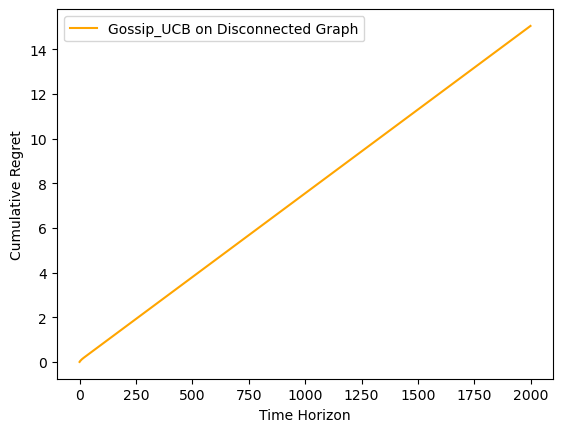

In [10]:

plot_data = np.transpose(np.array(regret_rec))
Gossip_UCB = plot_data.reshape(config['T'])
#plot_min = np.transpose(np.array(regret_rec_lw))
#plot_max = np.transpose(np.array(regret_rec_upp))
x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data.reshape(config['T'],1),label='Gossip_UCB on Disconnected Graph',color='orange')
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
#plt.fill_between(x_axis,plot_min.reshape(config['T'],1)[:,0],plot_max.reshape(config['T'],1)[:,0],color='darkorange')

#plt.legend(['eps = 1'])
#for i in range(4):
    #plt.fill_between(x_axis,plot_min[:,i],plot_max[:,i],color='blue',alpha=0.25)
# plt.plot(np.transpose(np.array(regret_rec_min)))
# plt.plot(np.transpose(np.array(regret_rec_max)))
# plt.legend(['eps = 1','eps = 2','eps = 5','None'])
# plt.title('')
# plt.show()
# plt.subplot(122)
# plt.semilogy(np.mean(regret_sum,0))
# plt.savefig(f'result_10_{repeat_mark}.pdf')
# plt.show()


In [11]:
#Algorithm: Dr-FedUCB
def main(M,c,K,h):
    #Simulation
    # different h, K, M, mu, sigma, c  
    # when c is not 0, 
    config = {}
    config['T'] = 2000
    config['L'] = 120
    config['M'] = M
    config['c'] = c
    config['K'] = K
    config['c1'] = 0.25
    config['h'] = h
    config['scale'] = 0.2
    config['mu'] = np.ones((config['M'], config['K']))
    print(config['mu'])
    for k in range(config['K']):
        config['mu'][:,k] = np.linspace(0.1,0.1+(k+1)*config['h']/config['K'],config['M'])
    config['sigma'] = config['scale']*np.ones((config['M'], config['K']))
    mu = config['mu']
    #mu = np.array(sorted(mu, reverse=True))
    print(mu)
    #bandit = MultiArmedBandit(num_arms, true_reward_means)
    T = config['T']
    num_agents =config['M']
    L = config['L']
    para = 0.6
    tau = 1
    #P = np.zeros((num_agents, num_arms))
    environment = Environment(config)
    #print(num_arms)
    itr = 50
    avg_regret = []
    lw_regret = []
    upp_regret = []
    for iteration in range(itr):
        bandit = []
        for player in range(config['M']):
            bandit.append(LocalMAB(num_agents, config['K']))

        #burn-in period  
        for t in range(L):
            arms = []
            for player in range(config['M']):
                chosen_action = t % config['K'] 
                arms.append(chosen_action)
            reward, G = environment.draw(arms, 'dis')  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = 1/config['M']
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)

        for k in range(config['K']):
            for i in range(config['M']):
                bandit[i].q_network[k] = sum([((config['M']/len(bandit[i].comm_reward))*bandit[i].P1[j] * bandit[i].comm_reward[j][k]) for j in bandit[i].comm_reward])

        i = 0
        #print("Estimated action values:", bandit[i].q_network)
        #print("Total reward:", bandit[i].total_reward)
        #print("maintained matrix:", bandit[i].P)

        #learning period 
        r = 0
        for t in range(L, T):
            arms = []
            for i in range(config['M']):
                flag = False
                for k in range(config['K']):
                    if bandit[i].counts_local[k] < bandit[i].counts_network[k] - config['K']:
                        flag = True
                chosen_action = bandit[i].choose_action(t, flag,config['c1'])
                arms.append(chosen_action)
                if chosen_action == 0:
                    r+=1
            reward, G = environment.draw(arms, 'dis')  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            #print(neighbors)
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].comm_reward_network[j] = bandit[j].q_network
                        bandit[i].comm_counts_network[j] = bandit[j].counts_network
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                        bandit[i].comm_reward[j] = bandit[i].q_local
                        bandit[i].comm_counts[j] = bandit[i].counts_local
                        bandit[i].comm_reward_network[j] = bandit[i].q_network
                        bandit[i].comm_counts_network[j] = bandit[i].counts_network
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = (config['M'])/((config['M'])**2)
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']-1):
                #print(bandit[i].comm_reward_network[0][0])
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].update_global(arms[i], reward[i])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)
            for i in range(config['M']-1,config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                #bandit[i].update_global(arms[i], reward[i])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)
        regret_t = [np.mean([bandit[i].regret_list[j] for i in range(config['M'])]) for j in range(len(bandit[1].regret_list))]
        avg_regret.append(regret_t)
        regret_lw = [np.percentile([bandit[i].regret_list[j] for i in range(config['M'])],5) for j in range(len(bandit[1].regret_list))]
     
        regret_upp = [np.percentile([bandit[i].regret_list[j] for i in range(config['M'])],95) for j in range(len(bandit[1].regret_list))]
        lw_regret.append(regret_lw)
        upp_regret.append(regret_upp)
        return avg_regret,lw_regret,upp_regret

avg_regret_list = []
lw_regret_list = []
upp_regret_list = []

tmp_regret, tmp_regret_lw, tmp_regret_upp = main(5,0.9, 2, 0.1)
avg_regret_list.append(tmp_regret)
lw_regret_list.append(tmp_regret_lw)
upp_regret_list.append(tmp_regret_upp)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]


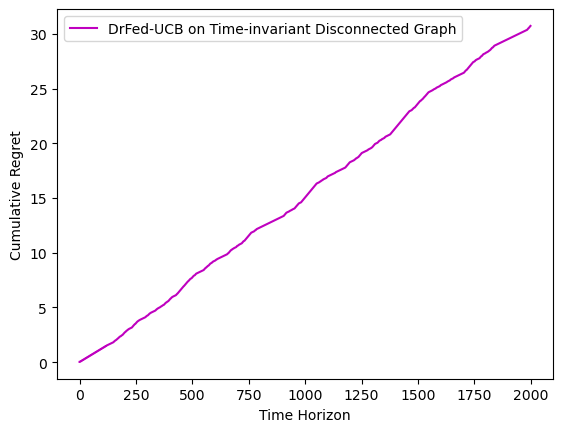

In [12]:
plot_data_o = np.transpose(np.array(avg_regret_list)).reshape((2000,1))
plt.plot(x_axis,plot_data_o,  label='DrFed-UCB on Time-invariant Disconnected Graph',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')

plt.legend()
plt.show()

In [13]:
#shuffling bandits 

import os
import datetime
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
class HomoBandit_0(Dataset):
    def __init__(self, n_epochs, n_agents, n_arms, rng, h = 0.1) -> None:
        super().__init__()
        mu = np.ones((n_agents, n_arms))
        for k in range(n_arms):
            mu[:,k] = np.linspace(0.1,0.1+(k+1)*h/n_arms,n_agents)
        L = np.zeros((n_arms,n_epochs,n_agents))
        for i in np.arange(n_agents):
            global_means = mu[i]
            L[:,:,i] = np.array(
            [rng.binomial(1, p, size=(n_epochs)) for p in global_means], 
            dtype=np.float32
        )
        self.data = np.transpose(L, (1, 2, 0))
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]

    def cumloss_of_best_arm(self):
        true_loss = np.mean(self.data, axis=1)
        cum_losses = np.cumsum(true_loss, axis=0)
        best_arm = np.argmin(cum_losses[-1,])
        return cum_losses[:,best_arm]
        

class StoBandit(HomoBandit_0):
    def __init__(self, n_epochs, n_agents, n_arms, activate_size, rng) -> None:
        super().__init__(n_epochs, n_agents, n_arms, rng)
        #period = int(d)+1
        #print(period)
        for t in range(n_epochs):
            means = [1/2,1/2+0.01]
            L_1 = np.array(
            [rng.binomial(1, p, size=(1, 1)) for p in means], 
            dtype=np.float32
        )
            self.data[t,n_agents-1,:] = np.transpose(L_1, (1, 2, 0))

In [14]:
import wandb
import torch
import numpy as np
import networkx as nx
import agent as fba
import env as fbe
from PIL import Image
from tqdm import tqdm
from matplotlib import cm
from torch.utils.data import DataLoader

def FedEXP3(config):
    use_cuda = torch.cuda.is_available()
    config['device'] = torch.device("cuda" if use_cuda else "cpu")
    rng = torch.Generator(device=config['device'])
    rng.manual_seed(config['seed'])

    # Create dataset
    env = config['env'].split('-')[0]
    if env == "HomoBandit":
        train_data = fbe.HomoBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            np.random.default_rng(
                int(config['env'].split('-')[-1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfActBandit':
        train_data = fbe.StoActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfFixActBandit':
        train_data = fbe.FixActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'StoBandit':
        train_data = StoBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    else:
        raise NotImplementedError("The "+env+" environment has not been implemented.")
    
    train_loader = DataLoader(
        train_data,
        batch_size=1, 
        shuffle=False
    )
    # compute cumulative loss of the best arm in hindsight
    best_cumu_loss = train_data.cumloss_of_best_arm()

    # Specify communcation network
    network = config['network'].split('-')[0]
    if network == 'COMPLETE':
        graph = nx.complete_graph(config['n_agents'])
    elif network == 'PATH':
        graph = nx.path_graph(config['n_agents'])
    elif network == 'Dis':
        graph = nx.erdos_renyi_graph(config['n_agents']-1,1)
        graph.add_node(config['n_agents']-1)  
    elif network == 'NONE':
        graph = nx.from_numpy_array(
            np.zeros([
                config['n_agents'], config['n_agents']
            ])
        )
    elif network == 'GRID':
        graph = nx.grid_graph([
            int(np.sqrt(config['n_agents'])),
            int(np.sqrt(config['n_agents']))
        ])
    elif network == 'RGG':
        r = float(config['network'].split('-')[1])
        # threshold = np.sqrt(np.log(config['n_agents']) ** 1.1 / config['n_agents'])
        # if r  < threshold:
        #     raise ValueError(
        #         'Please choose r >= ' + str(threshold)
        #     )
        graph = nx.random_geometric_graph(
            config['n_agents'], 
            r,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    elif network == 'ER':
        p = float(config['network'].split('-')[1])
        graph = nx.fast_gnp_random_graph(
            config['n_agents'], 
            p,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    else:
        raise NotImplementedError("The "+config['network']+" network has not been implemented.")
    comm_net = fba.CommNet(graph)

    # Specify the gossip
    if config['network'] == 'NONE':
        gossip_numpy = np.eye(config['n_agents'])
        spectral_gap = 0
    elif config['gossip'] == 'MaxDegree':
        gossip_numpy, spectral_gap = comm_net.max_deg_gossip(spectral_gap=True)
    elif config['gossip'] == 'Fast-SDP':
        gossip_numpy, spectral_gap = comm_net.fast_gossip('SDP', spectral_gap=True)
    else:
        raise NotImplementedError("The "+config['gossip']+" mechanism has not been implemented.")
    gossip = torch.tensor(gossip_numpy, device=config['device'])

    # Create FedExp3
    agent = fba.FedExp3(
        config['n_agents'],
        config['n_arms'],
        gossip, 
        config['lr'],
        expr_scheduler=fba.cube_root_scheduler(config['gamma']),
        device=config['device']
    )

    
    # Initialize WANDB
    if config['WANDB']:
        wandb.init(
            project=config['proj'], 
            reinit=True, 
            config=config, 
            job_type=config['jobtype']
        )
        prob_imgs = []

    cumu_loss = 0
    regret = []
    rounds = len(train_loader)
    for i, loss_matrix in tqdm(enumerate(train_loader), total=rounds):
        L_t = torch.squeeze(loss_matrix, 0).to(config['device'])
        # make actions
        actions, probs = agent.action(rng)
        # compute cumulative losses
        cumu_loss += torch.matmul(
            torch.mean(L_t.float(), dim=0),
            torch.transpose(actions.float(), 1, 0)
        )
        # update
        agent.update(L_t, actions, probs)
        
        regret.append(torch.mean(cumu_loss).item() - best_cumu_loss[i])
        #print(regret)

        # logging
        if config['WANDB']:
            wandb.log({
                'mean': torch.mean(cumu_loss).item() - best_cumu_loss[i],
                'max': torch.max(cumu_loss).item()- best_cumu_loss[i],
            })
            if i % (config['horizon'] // 10) == 0:
                prob_imgs.append(
                    wandb.Image(
                        Image.fromarray(
                            np.uint8(cm.viridis(probs.tolist())*255)
                        )
                    )
                )

    if config['WANDB']:
        wandb.log({"visual_probs": prob_imgs})
        wandb.log({'mixing_time': spectral_gap ** (-1/3)})
        wandb.finish()
    
    return regret 


In [15]:
def EXP3(config):
    use_cuda = torch.cuda.is_available()
    config['device'] = torch.device("cuda" if use_cuda else "cpu")
    rng = torch.Generator(device=config['device'])
    rng.manual_seed(config['seed'])

    # Create dataset
    env = config['env'].split('-')[0]
    if env == "HomoBandit":
        train_data = fbe.HomoBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            np.random.default_rng(
                int(config['env'].split('-')[-1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfActBandit':
        train_data = fbe.StoActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfFixActBandit':
        train_data = fbe.FixActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'StoBandit':
        train_data = StoBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    else:
        raise NotImplementedError("The "+env+" environment has not been implemented.")
    
    train_loader = DataLoader(
        train_data,
        batch_size=1, 
        shuffle=False
    )
    # compute cumulative loss of the best arm in hindsight
    best_cumu_loss = train_data.cumloss_of_best_arm()

    # Specify communcation network
    network = config['network'].split('-')[0]
    if network == 'COMPLETE':
        graph = nx.complete_graph(config['n_agents'])
    elif network == 'PATH':
        graph = nx.path_graph(config['n_agents'])
    elif network == 'Dis':
        graph = nx.erdos_renyi_graph(config['n_agents']-1,1)
        graph.add_node(config['n_agents']-1) 
    elif network == 'NONE':
        graph = nx.from_numpy_array(
            np.zeros([
                config['n_agents'], config['n_agents']
            ])
        )
    elif network == 'GRID':
        graph = nx.grid_graph([
            int(np.sqrt(config['n_agents'])),
            int(np.sqrt(config['n_agents']))
        ])
    elif network == 'RGG':
        r = float(config['network'].split('-')[1])
        # threshold = np.sqrt(np.log(config['n_agents']) ** 1.1 / config['n_agents'])
        # if r  < threshold:
        #     raise ValueError(
        #         'Please choose r >= ' + str(threshold)
        #     )
        graph = nx.random_geometric_graph(
            config['n_agents'], 
            r,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    elif network == 'ER':
        p = float(config['network'].split('-')[1])
        graph = nx.fast_gnp_random_graph(
            config['n_agents'], 
            p,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    else:
        raise NotImplementedError("The "+config['network']+" network has not been implemented.")
    comm_net = fba.CommNet(graph)

    # Specify the gossip
    if config['network'] == 'NONE':
        gossip_numpy = np.eye(config['n_agents'])
        spectral_gap = 0
    elif config['gossip'] == 'MaxDegree':
        gossip_numpy, spectral_gap = comm_net.max_deg_gossip(spectral_gap=True)
    elif config['gossip'] == 'Fast-SDP':
        gossip_numpy, spectral_gap = comm_net.fast_gossip('SDP', spectral_gap=True)
    else:
        raise NotImplementedError("The "+config['gossip']+" mechanism has not been implemented.")
    #gossip = torch.tensor(gossip_numpy, device=config['device'])
    degrees = [val for (node, val) in graph.degree()]
    D = np.diag(degrees)
    gossip_numpy = np.eye(len(degrees))
    gossip = torch.tensor(gossip_numpy, device=config['device'])


    # Create FedExp3
    agent = fba.FedExp3(
        config['n_agents'],
        config['n_arms'],
        gossip, 
        config['lr'],
        expr_scheduler=fba.cube_root_scheduler(config['gamma']),
        device=config['device']
    )

    
    # Initialize WANDB
    if config['WANDB']:
        wandb.init(
            project=config['proj'], 
            reinit=True, 
            config=config, 
            job_type=config['jobtype']
        )
        prob_imgs = []

    cumu_loss = 0
    regret = []
    rounds = len(train_loader)
    for i, loss_matrix in tqdm(enumerate(train_loader), total=rounds):
        L_t = torch.squeeze(loss_matrix, 0).to(config['device'])
        # make actions
        actions, probs = agent.action(rng)
        # compute cumulative losses
        cumu_loss += torch.matmul(
            torch.mean(L_t.float(), dim=0),
            torch.transpose(actions.float(), 1, 0)
        )
        # update
        agent.update(L_t, actions, probs)
        
        regret.append(torch.mean(cumu_loss).item() - best_cumu_loss[i])
        #print(regret)

        # logging
        if config['WANDB']:
            wandb.log({
                'mean': torch.mean(cumu_loss).item() - best_cumu_loss[i],
                'max': torch.max(cumu_loss).item()- best_cumu_loss[i],
            })
            if i % (config['horizon'] // 10) == 0:
                prob_imgs.append(
                    wandb.Image(
                        Image.fromarray(
                            np.uint8(cm.viridis(probs.tolist())*255)
                        )
                    )
                )

    if config['WANDB']:
        wandb.log({"visual_probs": prob_imgs})
        wandb.log({'mixing_time': spectral_gap ** (-1/3)})
        wandb.finish()
    
    return regret 


In [16]:
#FedEXP3 - Large M without shuffling; theorem 8 
itr = 50
regret_list = []
regret_exp3_list = []
for i in np.arange(itr):
    config = dict(
    proj = 'FedExp3',
    env = 'StoBandit-5',
    network = 'Dis',
    gossip = 'MaxDegree',
    n_agents = 5,
    n_arms = 2,                 
    horizon = 2000,                  
    lr = 0.15,
    gamma = 0.01,
    seed = 20160,
    WANDB = False,
    jobtype = 'test'
)
    regret_fedexp3_tmp = FedEXP3(config)
    regret_exp3_tmp = EXP3(config)
    regret_list.append(regret_fedexp3_tmp)
    regret_exp3_list.append(regret_exp3_tmp)

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 5476.47it/s]


['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


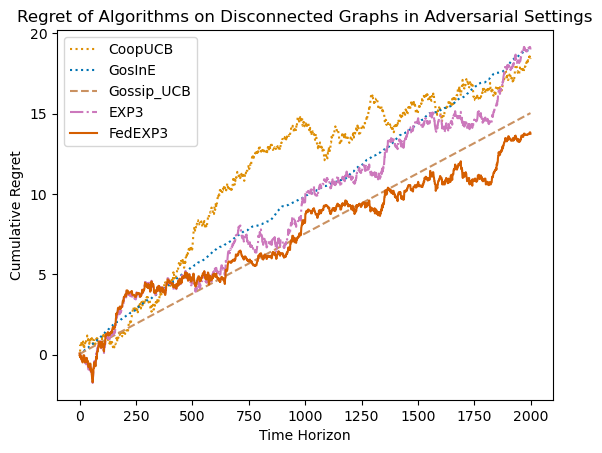

In [17]:
regret_fedexp3 = np.mean(regret_list, 0)
regret_exp3 = np.mean(regret_exp3_list, 0)
x_axis = np.arange(len(regret_fedexp3))
FedEXP3 = np.transpose(np.array(regret_fedexp3)).reshape((2000,1))
EXP3 = np.transpose(np.array(regret_exp3)).reshape((2000,1))

import matplotlib as mpl
import seaborn as sns

import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)

color_pal = sns.color_palette("colorblind", 10).as_hex()
colors = color_pal

print(colors)

plt.plot(x_axis,CoopUCB[1:], label='CoopUCB', color=colors[1],linestyle = ':')
plt.plot(x_axis,GosInE, label='GosInE',color=colors[0], linestyle = ':')

plt.plot(x_axis,Gossip_UCB, label='Gossip_UCB',color=colors[5], linestyle = '--')

plt.plot(x_axis,EXP3, label='EXP3',color=colors[4], linestyle = '-.')

plt.plot(x_axis,FedEXP3, label='FedEXP3',color=colors[3], linestyle = '-')





plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.title('Regret of Algorithms on Disconnected Graphs in Adversarial Settings')


plt.legend()
plt.show()

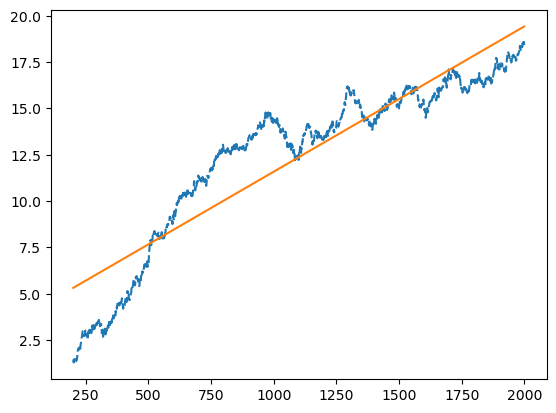

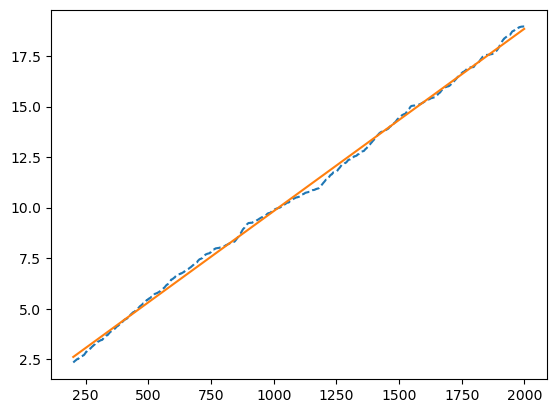

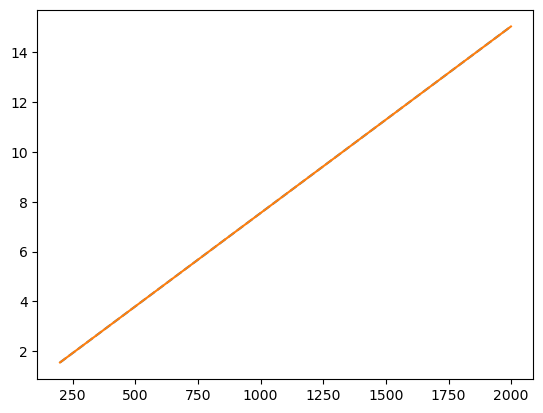

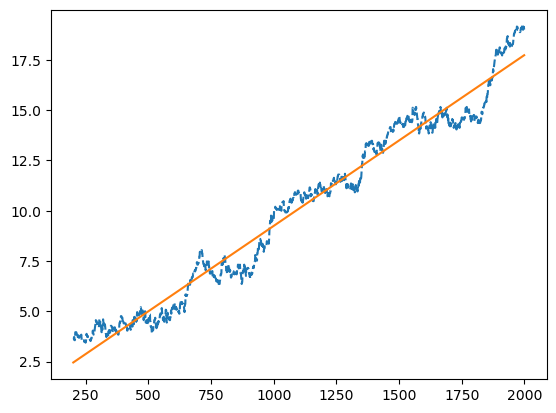

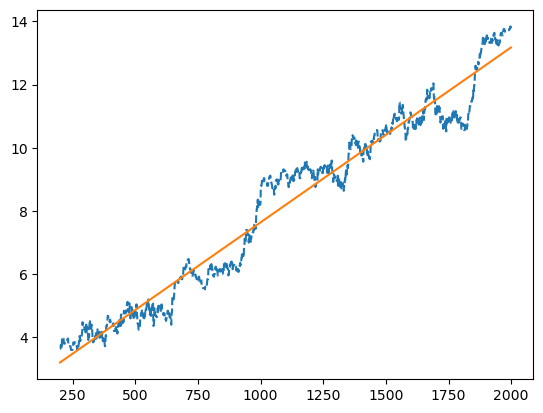

In [23]:
regret_dict = {}
regret_dict['CoopUCB'] = CoopUCB[1:]
regret_dict['GosInE'] = GosInE
regret_dict['Gossip_UCB'] = Gossip_UCB
regret_dict['EXP3'] = EXP3
regret_dict['FedEXP3'] = FedEXP3
alg = ['CoopUCB', 'GosInE', 'Gossip_UCB', 'EXP3', 'FedEXP3']


#log fit 
from scipy.optimize import curve_fit

def log_func(x, D, E):
    y = D*(x) + E
    return y

coeff = {}

fit = []
for i in np.arange(5):
    
    tmp = regret_dict[alg[i]]
    x = x_axis[200:].flatten()
    y = tmp[200:].flatten()

    parameters, covariance = curve_fit(log_func, x, y)
    fit_D = parameters[0]
    fit_E = parameters[1]
    
    coeff[alg[i]] = fit_D

    fit_log = log_func(x, fit_D, fit_E)

    plt.figure()

    plt.plot(x, y, '--', label='data')
    plt.plot(x, fit_log, '-', label='fit')
    fit.append(fit_log)
    plt.show()


In [24]:
coeff

{'CoopUCB': 0.007844249885728608,
 'GosInE': 0.009015798282035914,
 'Gossip_UCB': 0.007499999999999807,
 'EXP3': 0.008492180124817755,
 'FedEXP3': 0.005543458831690606}

In [25]:
import json

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
dumped = json.dumps(regret_dict, cls=NumpyEncoder)

with open("linear.json", "w") as outfile: 
    json.dump(dumped, outfile)

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


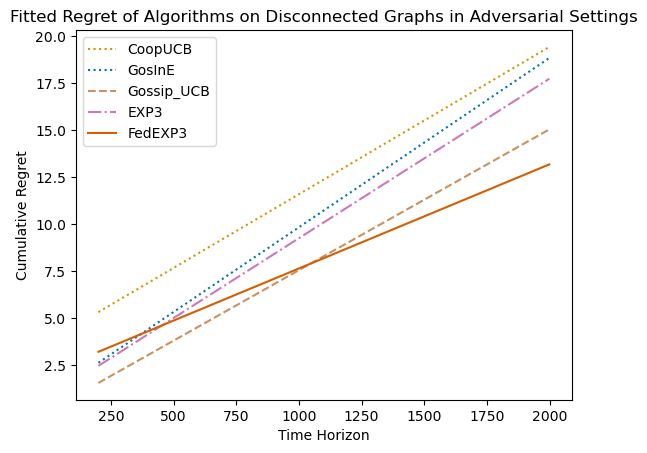

In [27]:

color_pal = sns.color_palette("colorblind", 10).as_hex()
colors = color_pal

print(colors)
x = x_axis[200:].flatten()


plt.plot(x,fit[0], label='CoopUCB', color=colors[1],linestyle = ':')
plt.plot(x,fit[1], label='GosInE',color=colors[0], linestyle = ':')

plt.plot(x,fit[2], label='Gossip_UCB',color=colors[5], linestyle = '--')

plt.plot(x,fit[3], label='EXP3',color=colors[4], linestyle = '-.')

plt.plot(x,fit[4], label='FedEXP3',color=colors[3], linestyle = '-')





plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.title('Fitted Regret of Algorithms on Disconnected Graphs in Adversarial Settings')


plt.legend()
plt.show()